In [124]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from scipy.spatial import KDTree
from numpy.linalg import svd

## 问题描述
在一个二维场景中，模拟机器人在不同位置扫描得到的激光束，然后根据两次扫描的激光束数据，计算机器人的位姿变换。

### 数据准备

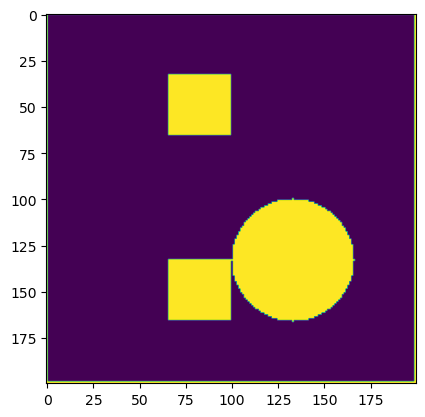

In [125]:
# 生成一个室内场景
def generate_scene(size):
    # 生成一个二维场景，0表示空，255表示墙壁
    scene = np.zeros((size, size), dtype=np.uint8)
    scene[0, :] = 255
    scene[-1, :] = 255
    scene[:, 0] = 255
    scene[:, -1] = 255
    scene[int(size/6):int(size/3), int(size/3):int(size/2)] = 255
    scene[int(size/3*2):int(size/6*5), int(size/3):int(size/2)] = 255
    # 画个圆
    cv2.circle(scene, (int(size/1.5), int(size/1.5)), int(size/6), 255, -1)
    return scene
scene = generate_scene(200)
plt.imshow(scene)

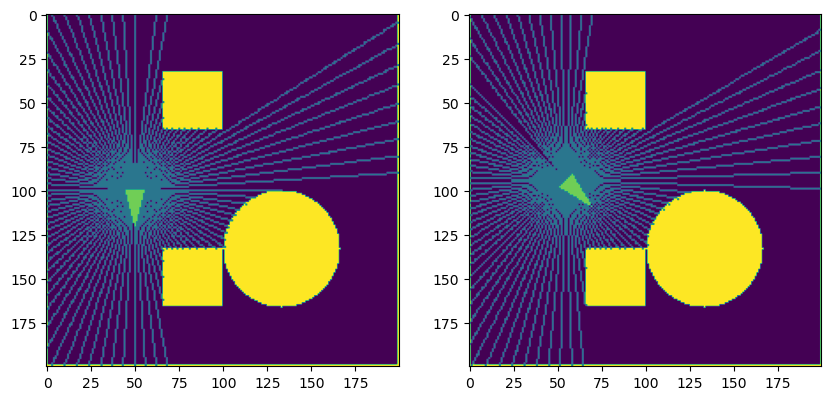

In [126]:
# 激光雷达参数
lidar_max_range = 10
lidar_min_range = 0.1
lidar_angle_resolution = np.pi / 50
lidar_angle_min = -np.pi
lidar_angle_max = np.pi
lidar_angle_num = int((lidar_angle_max - lidar_angle_min) / lidar_angle_resolution)
# 通过机器人位置和角度生成激光雷达数据
def generate_lidar_data(scene, robot_x, robot_y, robot_angle):
    # 扫描示意图
    scan_image = scene.copy()
    # 激光雷达数据
    lidar_data = np.zeros(lidar_angle_num, dtype=np.float32)
    # 生成激光雷达数据
    for i in range(lidar_angle_num):
        angle = robot_angle + lidar_angle_min + i * lidar_angle_resolution
        x = robot_x
        y = robot_y 
        while True:
            x += np.cos(angle)
            y += np.sin(angle)
            scan_image[int(x), int(y)] = 100
            if x < 0 or x >= scene.shape[0] or y < 0 or y >= scene.shape[1]:
                break
            if scene[int(x), int(y)] == 255:
                break
        lidar_data[i] = np.sqrt((x - robot_x) ** 2 + (y - robot_y) ** 2)
    # 三角绘制机器人位置（小角为朝向）
    robot_triangle = np.array([
        [robot_y + np.sin(robot_angle) * 20, robot_x + np.cos(robot_angle) * 20],
        [robot_y + np.sin(robot_angle + np.pi / 2) * 5, robot_x + np.cos(robot_angle + np.pi / 2) * 5],
        [robot_y + np.sin(robot_angle - np.pi / 2) * 5, robot_x + np.cos(robot_angle - np.pi / 2) * 5]
    ], dtype=np.int32)
    cv2.fillPoly(scan_image, [robot_triangle], 200)
    return lidar_data,scan_image
lidar_data_1, scan_image_1 = generate_lidar_data(scene, 100, 50, 0)
lidar_data_2, scan_image_2 = generate_lidar_data(scene, 95, 55, np.pi / 4)
# 可视化激光雷达数据
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.imshow(scan_image_1)
plt.subplot(122)
plt.imshow(scan_image_2)

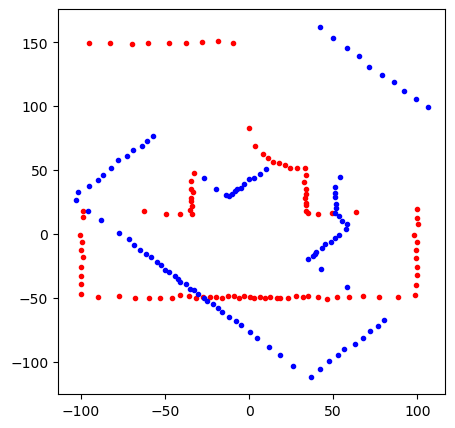

In [127]:
# 将range还原成坐标并加入一点噪声
lidar_coords_1 = np.zeros((lidar_angle_num, 2), dtype=np.float32)
lidar_coords_2 = np.zeros((lidar_angle_num, 2), dtype=np.float32)
for i in range(lidar_angle_num):
    angle = lidar_angle_min + i * lidar_angle_resolution
    lidar_coords_1[i, 0] = np.cos(angle) * lidar_data_1[i]+np.random.normal(0,0.5)
    lidar_coords_1[i, 1] = np.sin(angle) * lidar_data_1[i]+np.random.normal(0,0.5)
    lidar_coords_2[i, 0] = np.cos(angle) * lidar_data_2[i]+np.random.normal(0,0.5)
    lidar_coords_2[i, 1] = np.sin(angle) * lidar_data_2[i]+np.random.normal(0,0.5)
# 在一张图上用不同颜色绘制两个机器人的激光雷达数据
plt.figure(figsize=(5, 5))
plt.plot(lidar_coords_1[:, 0], lidar_coords_1[:, 1], 'r.')
plt.plot(lidar_coords_2[:, 0], lidar_coords_2[:, 1], 'b.')

### 迭代最近点（Iterative Closest Point, ICP）
icp求解方法一般有两种，一种使用SVD，另一种使用非线性最小二乘法，这里我们使用SVD方法。需要注意到的是，icp需要点对之间的匹配关系，一般会将靠的最近的点作为同一点，因此需要良好的初值估计。这里我们使用一个暴力搜索先大致得到匹配，再使用icp进行提高匹配精度。

best_x:  -8
best_y:  4
best_theta:  0.6283185307179586
best_error:  5.614092299595055


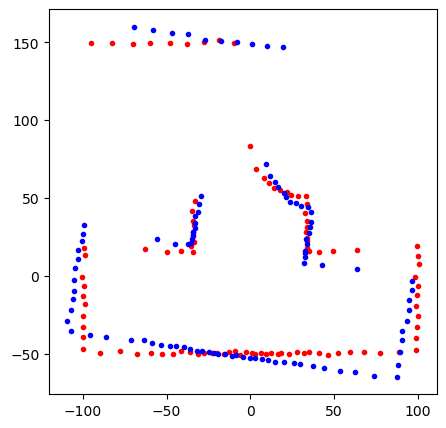

In [128]:
# 暴搜位姿匹配
def brute_force_match(lidar_coords_1, lidar_coords_2):
    # 两个位姿的x,y,theta的搜索范围
    x_range = np.arange(-10, 10, 2)
    y_range = np.arange(-10, 10, 2)
    theta_range = np.arange(-np.pi, np.pi, np.pi / 5)
    # 最佳匹配位姿
    best_x = 0
    best_y = 0
    best_theta = 0
    # 最佳匹配位姿的误差
    best_error = 100000000
    # 搜索
    for x in x_range:
        for y in y_range:
            for theta in theta_range:
                # 旋转矩阵
                rotation_matrix = np.array([
                    [np.cos(theta), -np.sin(theta)],
                    [np.sin(theta), np.cos(theta)]
                ])
                # 旋转后的激光雷达数据
                lidar_coords_2_rotated = np.matmul(rotation_matrix, lidar_coords_2.T).T
                # 平移后的激光雷达数据
                lidar_coords_2_rotated[:, 0] += x
                lidar_coords_2_rotated[:, 1] += y
                # 误差（最近邻距离的和，使用KDTree加速）
                error = 0
                kdtree = KDTree(lidar_coords_1)
                distances, indices = kdtree.query(lidar_coords_2_rotated)
                # 计算误差
                error = np.sum(distances) / distances.shape[0]                
                # 更新最佳匹配位姿
                if error < best_error:
                    best_error = error
                    best_x = x
                    best_y = y
                    best_theta = theta
    return best_x, best_y, best_theta, best_error
best_x, best_y, best_theta, best_error = brute_force_match(lidar_coords_1, lidar_coords_2)
print('best_x: ', best_x)
print('best_y: ', best_y)
print('best_theta: ', best_theta)
print('best_error: ', best_error)
# 可视化结果（将2号机器人的激光雷达数据旋转后与1号机器人的激光雷达数据对齐）
rotation_matrix = np.array([
    [np.cos(best_theta), -np.sin(best_theta)],
    [np.sin(best_theta), np.cos(best_theta)]
])
lidar_coords_2_rotated = np.matmul(rotation_matrix, lidar_coords_2.T).T
plt.figure(figsize=(5, 5))
plt.plot(lidar_coords_1[:, 0], lidar_coords_1[:, 1], 'r.')
plt.plot(lidar_coords_2_rotated[:, 0] + best_x, lidar_coords_2_rotated[:, 1] + best_y, 'b.')

error:  4.839306987323363
error:  3.8042613002850336
error:  2.623833839501625
error:  2.5819887220249575
error:  2.538291783829983
error:  2.4155618204723983
error:  2.213207304245759
error:  2.120976895939021
error:  2.064790339595939
error:  2.022936430079719
error:  1.987288059471691
R:  [[ 0.99999665 -0.00259019]
 [ 0.00259019  0.99999665]]
t:  [ 0.13702545 -0.14965112]


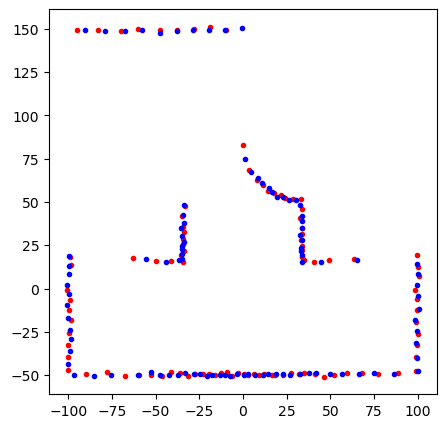

In [129]:
# 使用icp对点云进行配准
def icp(source, target):
    # 使用kdtree搜索最近邻作为匹配点
    kdtree = KDTree(target)
    distances, indices = kdtree.query(source)
    target = target[indices]
    # 初始化R和t
    R = np.eye(3)
    t = np.zeros((1, 3))
    # 去中心化
    source_mean = np.mean(source, axis=0)
    target_mean = np.mean(target, axis=0)
    source = source - source_mean
    target = target - target_mean
    # 计算协方差矩阵
    H = np.matmul(source.T, target)
    # 使用SVD分解计算旋转矩阵
    U, S, V = np.linalg.svd(H)
    R = np.matmul(V.T, U.T)
    # 计算平移矩阵
    t = target_mean.T - np.matmul(R, source_mean.T)
    return R, t

# 使用icp算法进行精确位姿匹配
for i in range(100):
    R, t = icp(lidar_coords_2_rotated, lidar_coords_1)
    lidar_coords_2_rotated = np.dot(R, lidar_coords_2_rotated.T).T + t
    # 计算误差
    kdtree = KDTree(lidar_coords_1)
    distances, indices = kdtree.query(lidar_coords_2_rotated)
    error = np.sum(distances) / distances.shape[0]
    print('error: ', error)
    if error < 2.0:
        break

print('R: ', R)
print('t: ', t)
# plot
plt.figure(figsize=(5, 5))
plt.plot(lidar_coords_1[:, 0], lidar_coords_1[:, 1], 'r.')
plt.plot(lidar_coords_2_rotated[:, 0], lidar_coords_2_rotated[:, 1], 'b.')